In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [55]:
import numpy as np
import pandas as pd
from pandas.plotting import table

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

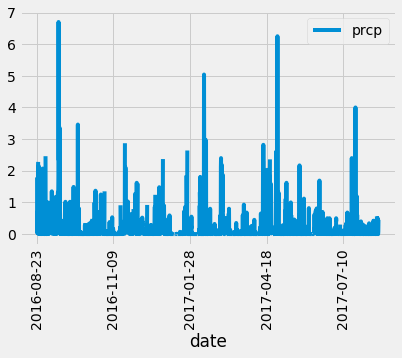

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Starting from the last data point in the database. 

# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017, 8, 23)-dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= prev_year).all()
# print(results)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','recipitation'])
df.set_index('date',inplace=True)
# print(df)

# Sort the dataframe by date
# df = df.sort_values("date")
df = df.sort_index()
# print(df)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [38]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
        filter(Measurement.station =='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

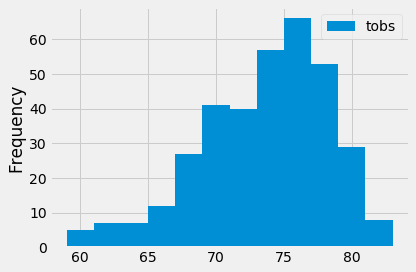

In [57]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
prev_year = dt.date(2017, 8, 23)-dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
        filter(Measurement.station =='USC00519281').\
        filter(Measurement.date >= prev_year).all()

#plotting the results as a histogram
df = pd.DataFrame(results, columns = ['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

In [59]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [67]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018, 8, 23)-dt.timedelta(days=365)
prev_year_end = dt.date(2018, 9, 23)-dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start, prev_year_end)[0]
print(tmin, tavg, tmax)

76.0 80.25 82.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


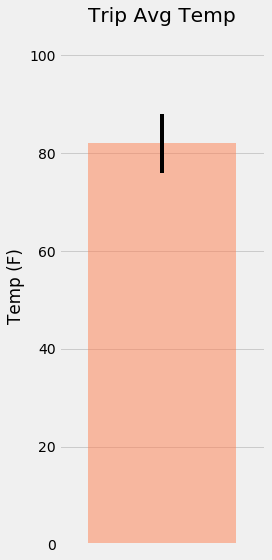

In [68]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [71]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prev_year_start = dt.date(2018, 8, 23)-dt.timedelta(days=365)
prev_year_end = dt.date(2018, 9, 23)-dt.timedelta(days=365)

sel=[Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]

results = session.query(*sel).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= prev_year_start).\
        filter(Measurement.date <= prev_year_end).\
        group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.45), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.08), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0)]


## Optional Challenge Assignment

In [ ]:
from sqlalchemy import extract

june_temps = session.query(Measurement).filter(extract('month', Measurement.date) == 6)
june_temps_list = [temp.tobs for temp in june_temps]
print(np.mean(june_temps_list))


dec_temps = session.query(Measurement).filter(extract('month', Measurement.date) == 12)
dec_temps_list = [temp.tobs for temp in dec_temps]
print(np.mean(dec_temps_list))

In [ ]:
from scipy import stats
stats.ttest_ind(june_temps_list, dec_temps_list)

In [72]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [94]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date='2018-08-23'
end_date='2018-09-23'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)
# print(trip_dates)

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')
# print(trip_month_day)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for n in trip_month_day:
    normals.append(*daily_normals(n))
normals

DatetimeIndex(['2018-08-23', '2018-08-24', '2018-08-25', '2018-08-26',
               '2018-08-27', '2018-08-28', '2018-08-29', '2018-08-30',
               '2018-08-31', '2018-09-01', '2018-09-02', '2018-09-03',
               '2018-09-04', '2018-09-05', '2018-09-06', '2018-09-07',
               '2018-09-08', '2018-09-09', '2018-09-10', '2018-09-11',
               '2018-09-12', '2018-09-13', '2018-09-14', '2018-09-15',
               '2018-09-16', '2018-09-17', '2018-09-18', '2018-09-19',
               '2018-09-20', '2018-09-21', '2018-09-22', '2018-09-23'],
              dtype='datetime64[ns]', freq='D')


[(67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.84, 85.0),
 (69.0, 77.0, 82.0),
 (67.0, 76.66666666666667, 83.0),
 (69.0, 76.13725490196079, 83.0),
 (68.0, 76.27083333333333, 84.0),
 (66.0, 75.91489361702128, 84.0),
 (66.0, 74.91111111111111, 81.0),
 (64.0, 75.18, 82.0),
 (66.0, 76.22222222222223, 83.0),
 (68.0, 76.36538461538461, 84.0),
 (67.0, 76.61224489795919, 85.0),
 (70.0, 76.69565217391305, 83.0),
 (68.0, 75.89795918367346, 85.0),
 (68.0, 75.875, 82.0),
 (69.0, 75.98076923076923, 85.0),
 (67.0, 76.14, 81.0),
 (70.0, 77.40384615384616, 86.0),
 (68.0, 76.57692307692308, 83.0),
 (67.0, 75.85106382978724, 84.0),
 (68.0, 76.34693877551021, 87.0),
 (69.0, 76.14583333333333, 83.0),
 (67.0, 76.44897959183673, 84.0),
 (69.0, 76.37254901960785, 84.0),
 (67.0,

In [104]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
df['date']=trip_dates
df.set_index('date',inplace=True)

df

,tmin,tavg,tmax
date,,,
2018-08-23,67.0,76.692308,87.0
2018-08-24,70.0,75.961538,84.0
2018-08-25,69.0,76.960784,82.0
2018-08-26,71.0,76.568627,84.0
2018-08-27,68.0,76.283019,84.0
2018-08-28,67.0,76.734694,86.0
2018-08-29,70.0,76.235294,85.0
2018-08-30,68.0,76.416667,84.0
2018-08-31,67.0,76.840000,85.0


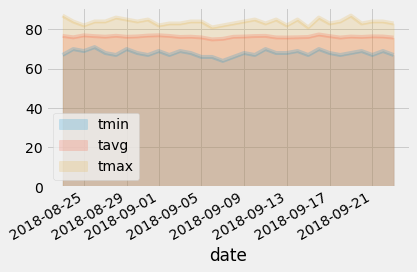

In [114]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()